#  Ultimate Technologies Inc. Take-Home Challenge
## August Perez

Springboard Data Science track unit 37.2

In [1]:
#imports

# data manipulation and math

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import datetime as dt

# plotting and visualization

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

#modeling & pre-processing

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#
import warnings
    #reminder code so I can ignore warnings for single code cells:
    # warnings.filterwarnings('ignore')
    # warnings.resetwarnings()

# Part 1 - Exploratory data analysis
The logins.json file contains (simulated) timestamps of user logins in a particular geographic location.

**Aggregate these login counts based on 15minute time intervals**,

and **visualize and describe the resulting time series** of login counts in **ways that best characterize the underlying patterns of the demand**. 

Please **report/illustrate important features of the demand**, such as daily cycles. If there are **data quality issues, please report them**.

In [2]:
#load data

df_logins = pd.read_json('logins.json')
df_logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


## aggregate by 15min intervals

In [4]:
df_logins.set_index('login_time', inplace=True)

In [5]:
aggregated = df_logins.resample('15min').size()
aggregated

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15min, Length: 9788, dtype: int64

In [6]:
#back to a dataframe instead of a series
df_aggregated = aggregated.to_frame(name='login_count')
print(df_aggregated.head())
print()
print(df_aggregated.tail())

                     login_count
login_time                      
1970-01-01 20:00:00            2
1970-01-01 20:15:00            6
1970-01-01 20:30:00            9
1970-01-01 20:45:00            7
1970-01-01 21:00:00            1

                     login_count
login_time                      
1970-04-13 17:45:00            5
1970-04-13 18:00:00            5
1970-04-13 18:15:00            2
1970-04-13 18:30:00            7
1970-04-13 18:45:00            6


In [7]:
df_aggregated.describe()

,login_count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [8]:
df_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   login_count  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


## Visualize & describe

visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand

### Visualize

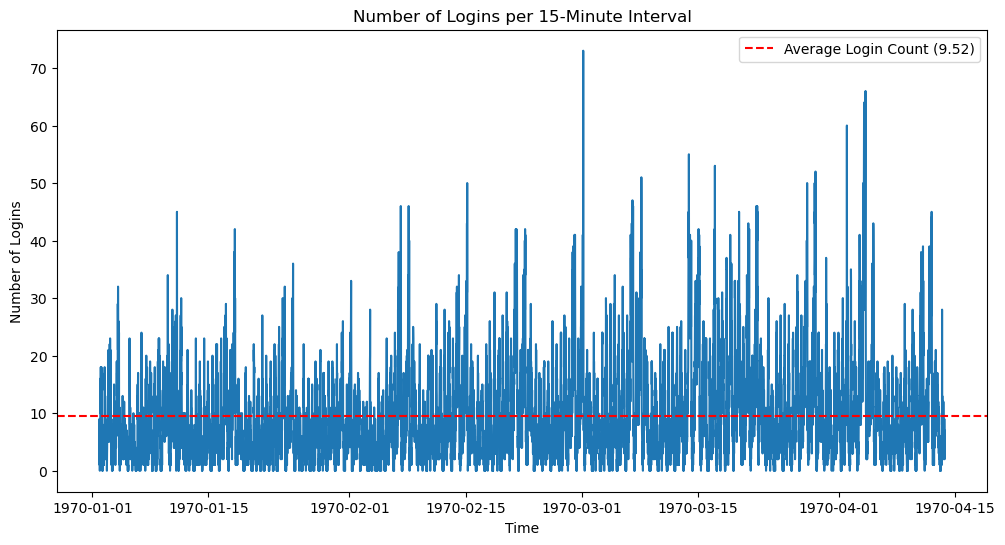

In [9]:
average_login_count = df_aggregated['login_count'].mean()

plt.figure(figsize=(12, 6))
#sns.lineplot(x='login_time', y='login_count', data=df_aggregated)
sns.lineplot(x=df_aggregated.index, y='login_count', data=df_aggregated)
plt.axhline(y=average_login_count, color='red', linestyle='--', label=f'Average Login Count ({average_login_count:.2f})')
plt.title('Number of Logins per 15-Minute Interval')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.legend()
plt.show()

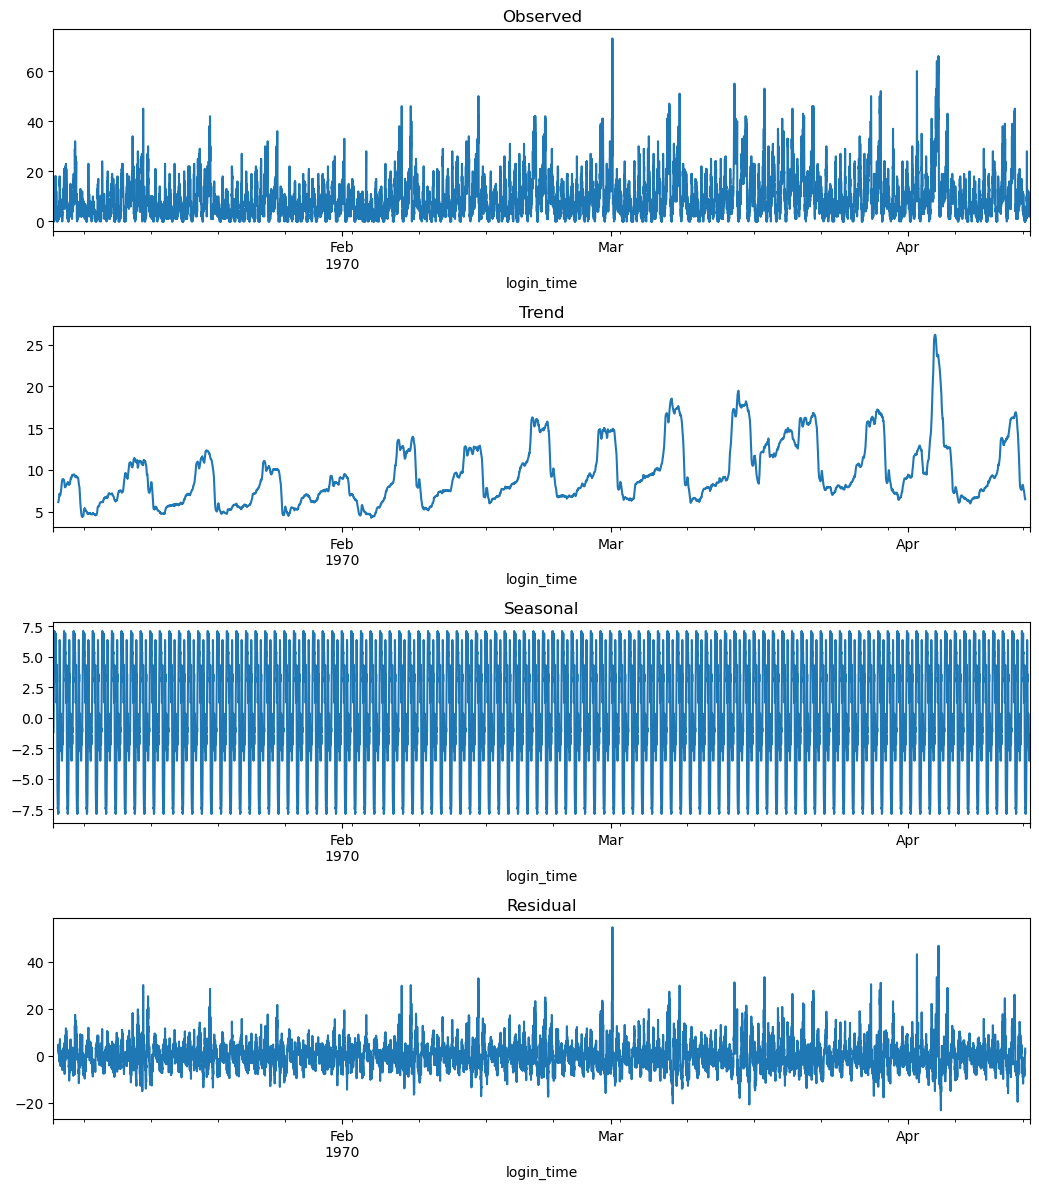

In [10]:
decomposition = seasonal_decompose(df_aggregated['login_count'], model='additive', period=96)  # 96 periods for daily seasonality in 15-min intervals

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10.5, 12))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

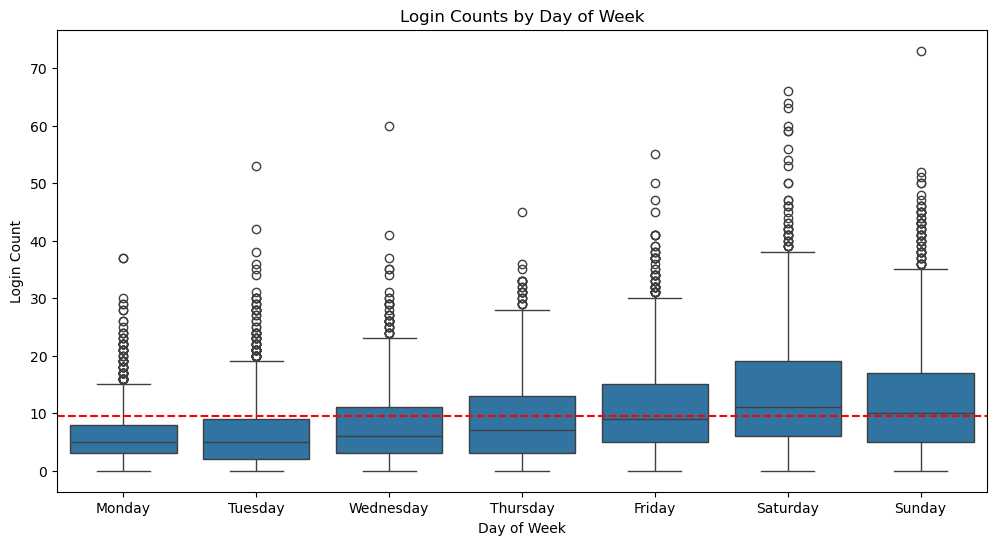

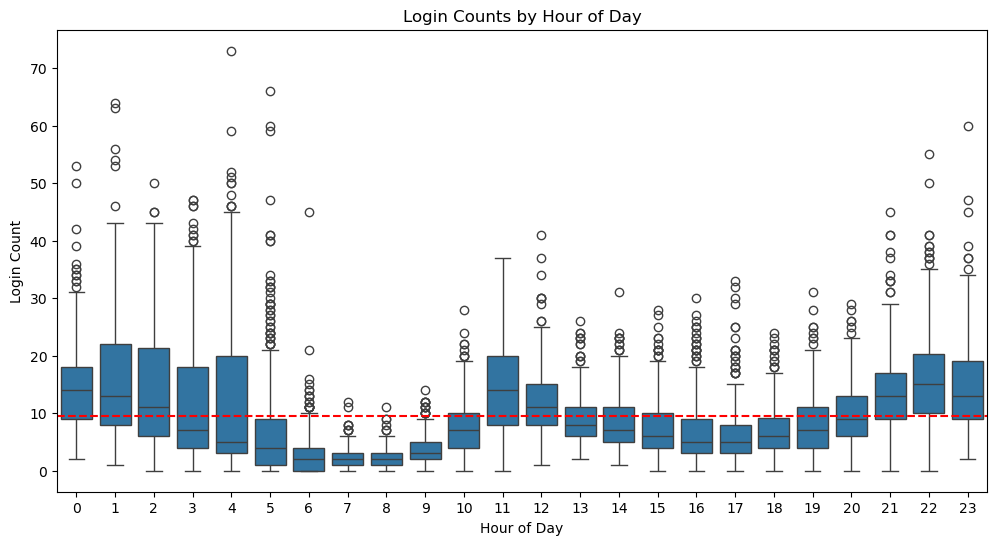

In [11]:
# Extract day of week and hour from the login_time index
df_aggregated['day_of_week'] = df_aggregated.index.dayofweek
df_aggregated['hour'] = df_aggregated.index.hour

# Avg logins by day of week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='login_count', data=df_aggregated)
plt.title('Login Counts by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Login Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.axhline(y=average_login_count, color='red', linestyle='--', label=f'Average Login Count ({average_login_count:.2f})')
plt.show()

# Avg logins by hour of day
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='login_count', data=df_aggregated)
plt.title('Login Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Login Count')
plt.axhline(y=average_login_count, color='red', linestyle='--', label=f'Average Login Count ({average_login_count:.2f})')
plt.show()

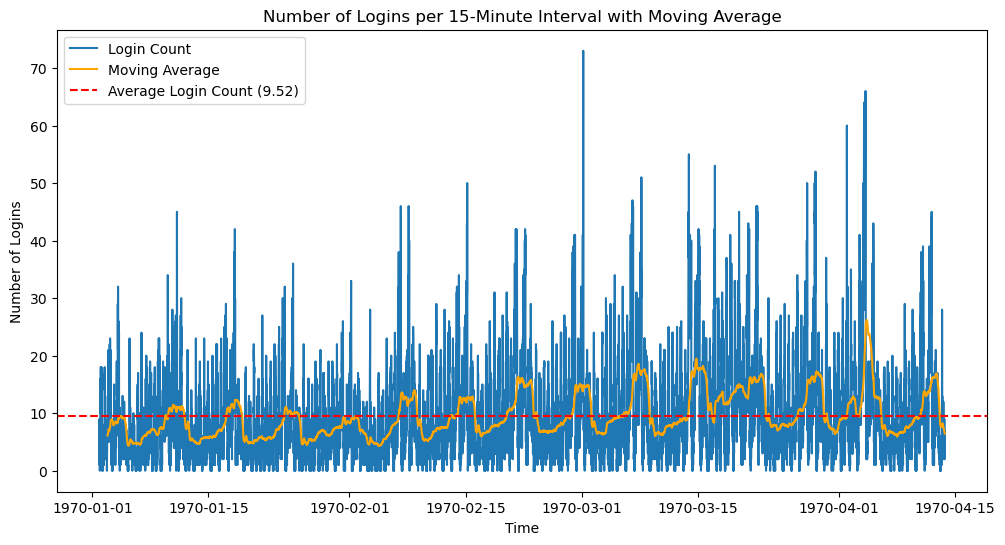

In [12]:
# Add col for moving average (window=96 for daily smoothing in 15-min intervals)
df_aggregated['moving_average'] = df_aggregated['login_count'].rolling(window=96).mean()

#time series with moving average
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_aggregated.index, y='login_count', data=df_aggregated, label='Login Count')
sns.lineplot(x=df_aggregated.index, y='moving_average', data=df_aggregated, color='orange', label='Moving Average')
plt.axhline(y=average_login_count, color='red', linestyle='--', label=f'Average Login Count ({average_login_count:.2f})')
plt.title('Number of Logins per 15-Minute Interval with Moving Average')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.legend()
plt.show()

### Describe

- Overall Trend:
    - An overall positive (increasing) trend of logins per 15min for Jan to Apr in 1970
- Average Login Count:
    - 9.52 logins per 15min
- Decomposition:
    - Trend patterns:
        - Highest login counts near end of weeks
        - Steady overall increase in login counts
    - Seasonality:
        - A +/- range of 7.5 logins for daily change
- Day of Week Analysis:
    - Slow increase of avg logins starting Monday (at lowest avg count).
    - Peak of avg logins: Saturday
    - Sunday has reduced avg login count from Sat
        - Highest login count occurred on sunday for single possible outlier
    - Only Sat & Sun have avg login counts >= than total avg
- Hour Analysis:
    - Hr's with above avg login counts: 0, 1, 2, 11, 12, 21, 22, 23
        - Most logins in the late hours of the day (9pm - 2am) & 2 hrs in middle of day (11am & 12pm)
    - Hr's of 6am - 9am have the least amount of user logins

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms:
- Weekdays
    - Ultimate Gotham is most active at night
    - Ultimate Metropolis is most active during the day
- Weekends
    - there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city.

The Ultimate managers of city operations for the two cities have proposed an **experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.**


1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success.

    Please provide details on:

        a) how you will implement the experiment

        b) what statistical test(s) you will conduct to verify the significance of the observation

        c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

AP:


1. key measure of success (encouraging driver partners to serve both cities)
    - Metric: Change in percent of driver partners serving both cities from percent of driver partners serving only one city (Difference between percent before and after the reimbursement policy took effect)
    - Why:
        - This metric directly captures the intended outcome of the experiment
        - Quantifiable measure that can be tracked over time to observe changes in driver behavior
2. Practical Experiment Design

        a) Implementation:
            - Before experiment start
                - Data collection before reimbursement policy (obtain a baseline)
                    - Duration: 1 month
                    - Data collected:
                        - Number of trips completed by Gotham driver partners.
                        - Number of trips completed by Metropolis driver partners.
                        - Number of trips completed by driver partners in both cities.
                        - Toll costs incurred by driver partners.
                        - Driver partner ID's (to help determine how the policy change affects individual drivers)
            - Start Experiement
                - Duration: 1 month after implementing the toll reimbursement policy.
                - Conditions: Reimburse all toll costs for driver partners who travel between Gotham and Metropolis.
                - Collect same data as Before Experiment phase
        b) Statistical Tests:
            - z-test to determine if the change in percent of drivers servicing both cities is significant
            - paired t-test to compare the number of trips in both cities by the same drivers
        c) Interpretation and Recommendations:
            - Interpretation:
                - Significant Increase: If the statistical tests show a significant increase in the proportion of drivers serving both cities, it indicates that the toll reimbursement policy is effective.
                - No Significant Change: If there is no significant change, the policy may not be effective, and further analysis would be needed to understand the barriers.
            - Recommendations:
                - Positive Outcome:
                    - Continue the toll reimbursement policy as it successfully encourages drivers to serve both cities. Monitor other metrics such as driver satisfaction, total trip numbers, and customer wait times to ensure the policy's holistic effectiveness.
                - Negative or No Significant Outcome:
                    - Investigate other potential barriers preventing drivers from serving both cities (e.g., time of day, traffic conditions, earnings differences).

            - Caveats:
                - External Factors: Consider external factors that might influence driver behavior, such as fuel prices, weather conditions, or major events in the cities.
                - Long-term Effects: Assess whether the observed changes are sustained over a longer period or if drivers revert to previous behaviors.
                - Data Accuracy: Ensure accurate data collection and consider any biases that might arise from drivers' self-reporting or data entry errors.

# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. Sample dataset (file ultimate_data_challenge.json) of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

**Understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.**

See below for a detailed description of the dataset.

1. **Perform any cleaning, exploratory analysis, and/or visualizations** to use the provided
data for this analysis. What fraction of the observed users were retained?

2. **Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system**. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

3. Briefly **discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention** (again, a few sentences will suffice).

Data description:
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

## 1. Cleaning, EDA, Visualizations

In [13]:
df_ult = pd.read_json('ultimate_data_challenge.json')

In [14]:
print(df_ult.info())
df_ult.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [22]:
df_ult.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,50000,3,Winterfell,23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trips_in_first_30_days,50000.0,NaN,NaN,NaN,2.2782,3.792684,0.0,0.0,1.0,3.0,125.0
signup_date,50000,31,2014-01-18,2948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,50000.0,NaN,NaN,NaN,4.601306,0.564977,1.0,4.5,4.7,5.0,5.0
avg_surge,50000.0,NaN,NaN,NaN,1.074764,0.222336,1.0,1.0,1.0,1.05,8.0
last_trip_date,50000,182,2014-06-29,2036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone,50000,2,iPhone,34978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surge_pct,50000.0,NaN,NaN,NaN,8.849536,19.958811,0.0,0.0,0.0,8.6,100.0
ultimate_black_user,50000,2,False,31146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,50000.0,NaN,NaN,NaN,60.926084,37.081503,0.0,33.3,66.7,100.0,100.0


### Missing Values

In [15]:
#nulls per col
missing_values = df_ult.isna().sum()
missing_percentages = (missing_values / len(df_ult)) * 100

missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentages})
missing_data.sort_values(by='Missing Values', ascending=False)

,Missing Values,Percentage
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000


In [16]:
#total rows with any number of nulls
print(df_ult.isna().any(axis=1).sum())
print('\n', (df_ult.isna().any(axis=1).sum() / len(df_ult)) *100, '%')

8555

 17.11 %


In [17]:
col_nulls = ['avg_rating_of_driver', 'phone', 'avg_rating_by_driver']

df_ult[col_nulls].describe(include='all')

,avg_rating_of_driver,phone,avg_rating_by_driver
count,41878.000000,49604,49799.000000
unique,NaN,2,NaN
top,NaN,iPhone,NaN
freq,NaN,34582,NaN
mean,4.601559,NaN,4.778158
std,0.617338,NaN,0.446652
min,1.000000,NaN,1.000000
25%,4.300000,NaN,4.700000
50%,4.900000,NaN,5.000000
75%,5.000000,NaN,5.000000


I feel comfortable with **imputing the mean for 'avg_rating_of_driver' & 'avg_rating_by_driver', and the mode for 'phone'**

In [18]:
#round to 1st decimal place to keep consistency of values within the cols
df_ult['avg_rating_of_driver'] = df_ult['avg_rating_of_driver'].fillna(value=round(df_ult['avg_rating_of_driver'].mean(), 1))

df_ult['avg_rating_by_driver'] = df_ult['avg_rating_by_driver'].fillna(value=round(df_ult['avg_rating_by_driver'].mean(), 1))

df_ult['phone'] = df_ult['phone'].fillna(value= 'iPhone')

In [19]:
df_ult.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

### Check col types

In [20]:
df_ult.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [23]:
df_ult.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,50000,3,Winterfell,23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trips_in_first_30_days,50000.0,NaN,NaN,NaN,2.2782,3.792684,0.0,0.0,1.0,3.0,125.0
signup_date,50000,31,2014-01-18,2948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,50000.0,NaN,NaN,NaN,4.601306,0.564977,1.0,4.5,4.7,5.0,5.0
avg_surge,50000.0,NaN,NaN,NaN,1.074764,0.222336,1.0,1.0,1.0,1.05,8.0
last_trip_date,50000,182,2014-06-29,2036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone,50000,2,iPhone,34978,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surge_pct,50000.0,NaN,NaN,NaN,8.849536,19.958811,0.0,0.0,0.0,8.6,100.0
ultimate_black_user,50000,2,False,31146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,50000.0,NaN,NaN,NaN,60.926084,37.081503,0.0,33.3,66.7,100.0,100.0


In [25]:
#convert to category
df_ult['city'] = df_ult['city'].astype('category')
df_ult['phone'] = df_ult['phone'].astype('category')

#convert to datetime
df_ult['last_trip_date'] = pd.to_datetime(df_ult['last_trip_date'])
df_ult['signup_date'] = pd.to_datetime(df_ult['signup_date'])

df_ult.dtypes

city                            category
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                           category
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

### Retention Rate

In [26]:
df_ult['retained'] = df_ult['last_trip_date'] >= '2014-06-01'
retention_rate = df_ult['retained'].mean()
print(f'Retention rate: {retention_rate:.2%}')

Retention rate: 37.61%


#### Visualize retention rate

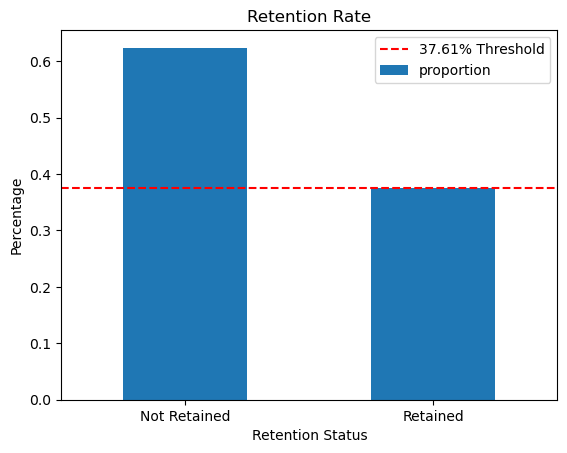

In [31]:
df_ult['retained'].value_counts(normalize=True).plot(kind='bar')
plt.title('Retention Rate')
plt.xlabel('Retention Status')
plt.ylabel('Percentage')
plt.xticks(ticks=[0, 1], labels=['Not Retained', 'Retained'], rotation=0)
plt.axhline(y=0.3761, color='red', linestyle='--', label='37.61% Threshold')

plt.legend()
plt.show()

### Outlier check

#### Visualizing numerical cols with boxplots

In [32]:
df_ult.dtypes

city                            category
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                           category
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
retained                            bool
dtype: object

In [35]:
cols_num = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']
cols_cat = ['city', 'phone', 'ultimate_black_user']
cols_time = ['signup_date', 'last_trip_date']

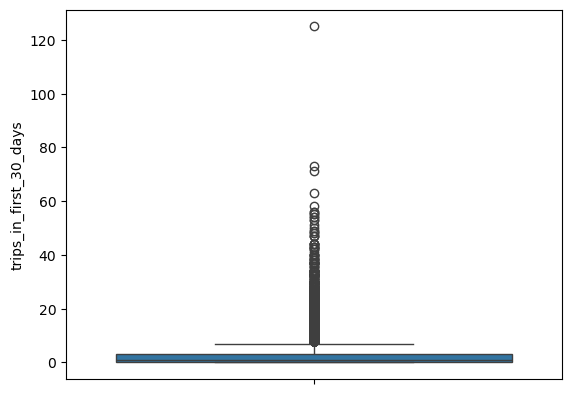

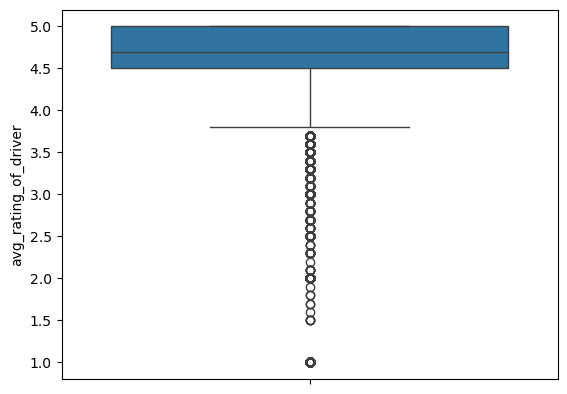

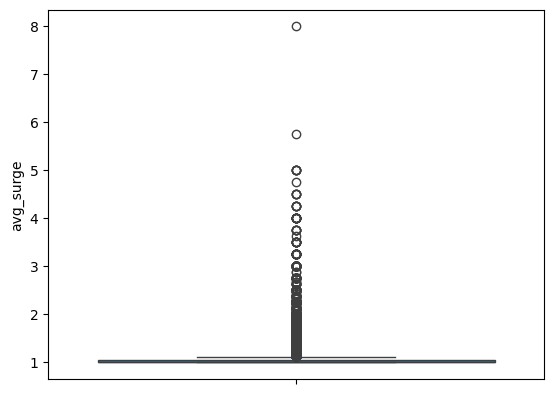

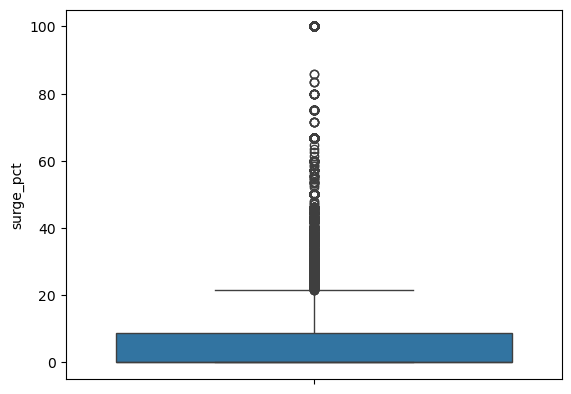

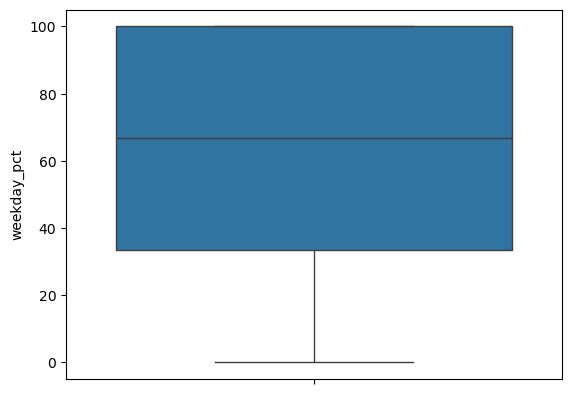

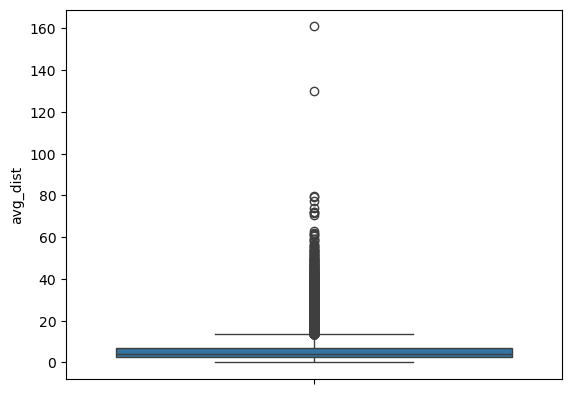

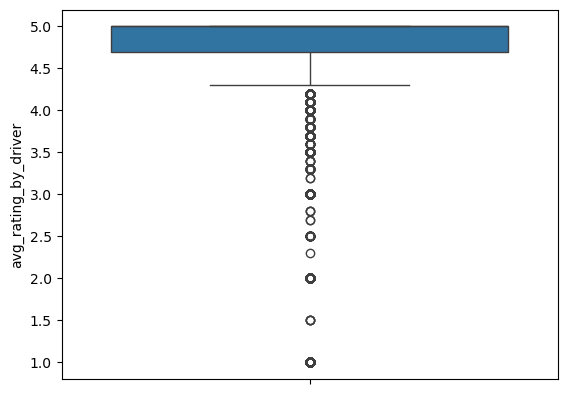

In [36]:
for col in cols_num:
    sns.boxplot(df_ult[col])
    plt.show()